In [1]:
from pathlib import Path
import json

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

from scipy.stats import lognorm

from astropy import stats
from astropy.time import Time, TimezoneInfo
import astropy.units as u
from astropy.visualization import time_support, hist
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, TETE
from astropy.io import ascii

from photutils.aperture import ApertureStats

from timdimm_tng.ser import load_ser_file
from timdimm_tng.analyze_cube import find_apertures, analyze_dimm_cube, timdimm_seeing

time_support(simplify=True)

<astropy.visualization.time.time_support.<locals>.MplTimeConverter at 0x121aa0560>

In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

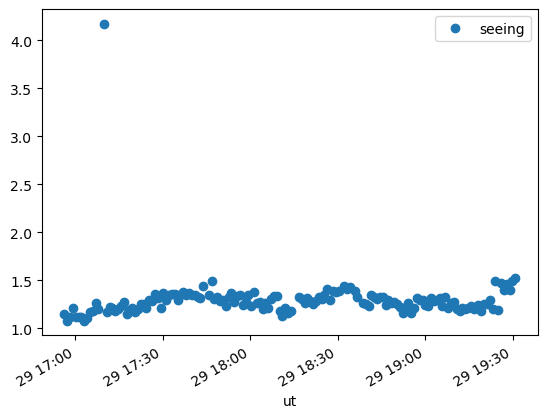

In [3]:
df = pd.read_csv(Path.home() / "SAAO" / "seeing.csv").dropna(how='any')
df = df[df['seeing'] < 10]
df = df[df['seeing'] > 0.5]
df = df.set_index(pd.DatetimeIndex(df['time'], name='ut'))
lastday = df.loc[df.index > (df.index[-1] - pd.Timedelta(14, 'h'))]
feb22 = lastday.plot(y='seeing', style='o').get_figure()
#feb22.savefig('feb22.pdf')

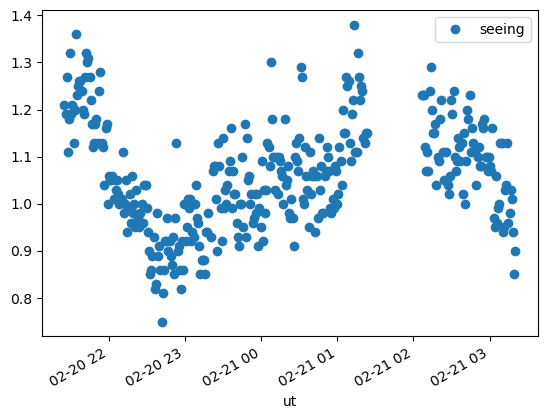

In [4]:
yday = df.loc["2024-02-20 21:00":"2024-02-21 07:00"]
feb21 = yday.plot(y='seeing', style='o').get_figure()
feb21.savefig('feb21.pdf')

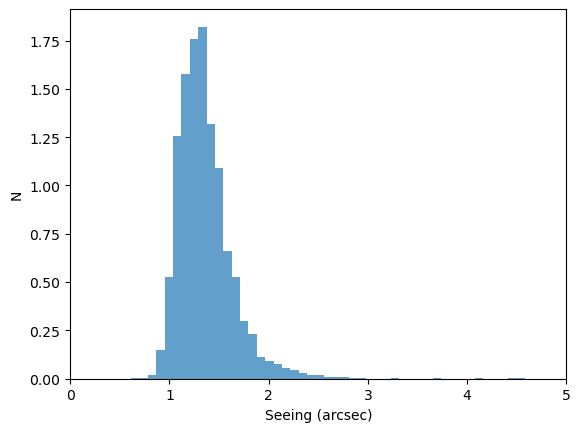

In [5]:
hist(df['seeing'][df['seeing'] < 10.0], bins='scott', histtype='stepfilled', alpha=0.7, density=True)
plt.xlim(0, 5)
plt.xlabel('Seeing (arcsec)')
plt.ylabel('N')
plt.show()

In [6]:
np.median(df['seeing'])

1.31

In [7]:
df.describe()

,seeing,airmass,azimuth,exptime
count,24143.000000,24143.000000,24143.000000,24143.000000
mean,1.419651,1.181669,193.338761,0.001341
std,0.697215,0.095284,29.529497,0.001275
min,0.530000,1.003000,97.300000,0.000200
25%,1.180000,1.129000,169.000000,0.001000
50%,1.310000,1.164000,201.300000,0.001000
75%,1.490000,1.237000,217.900000,0.001000
max,9.990000,1.556000,250.500000,0.005000


In [8]:
stats.sigma_clipped_stats(df['seeing'], sigma=10, maxiters=5)

(1.357462980005015, 1.31, 0.26791356906217556)

In [5]:
qe_tab = Table.read("~/MMT/timdimm_tng/notebooks/asi432mm_qe.csv", format="ascii.csv", names=["wavelength", "qe"])
np.sum(qe_tab["qe"] * qe_tab["wavelength"]) /np.sum(qe_tab["qe"])

639.375040081782

In [6]:
206265 * 9e-6 / 2.5

0.7425539999999999

In [7]:
plt.close('all')

In [58]:
testfile = Path.home() / "SAAO/timdimm_data/indi_2023-06-24/indi_record_2023-06-24@18-21-31.ser"
testfile = Path.home() / "SAAO/timdimm_data/indi_2023-06-24/indi_record_2023-06-24@18-18-32.ser"
testfile = Path.home() / "SAAO/timdimm_data/indi_2023-07-03/peacock.ser"
testfile = Path.home() / "find_boxes.ser"
testfile = Path.home() / "SAAO/bad4.ser"
testfile = Path.home() / "MMT/fassdimm_data/20241025/bad1.ser"
#testfile = Path.home() / "SAAO/seeing_2024-04-30T04:30+02:00.ser"
#testfile = Path.home() / "SAAO/seeing_2024-05-05T01:57+02:00.ser"
#testfile = Path.home() / "SAAO/timdimm_data/indi_2023-12-08/indi_record_2023-12-08@20-48-35.ser"
#testfile = Path.home() / "SAAO/timdimm_data/indi_2024-01-20/indi_record_2024-01-20@02-33-24.ser"
d = load_ser_file(testfile)

(<Quantity 0.89251472 arcsec>, 0)

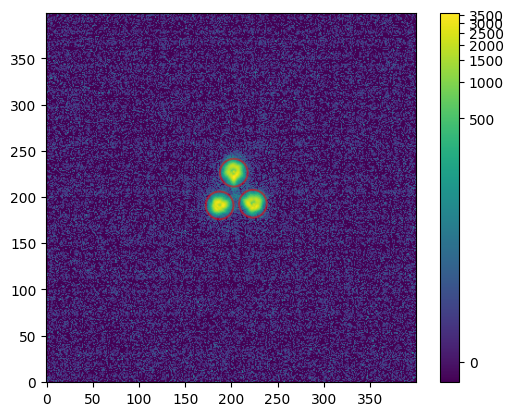

In [61]:
airmass = 1/np.cos(90 * u.deg - 62 * u.deg)
airmass = 1.0
results = analyze_dimm_cube(testfile, airmass=airmass, napertures=3, plot=True)
results["seeing"], results['N_bad']

array([[1070.81075633,  453.30611511],
       [1087.51331268,  491.0496208 ],
       [1109.03775414,  455.44354396]])

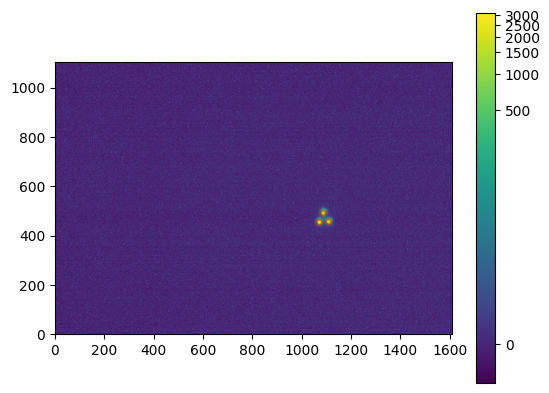

In [49]:
aperture_data = load_ser_file(Path.home() / "MMT/fassdimm_data/20241025/find_boxes.ser")
aperture_image = np.mean(aperture_data['data'], axis=0)
aps = find_apertures(aperture_image, ap_size=11, brightest=3, plot=True)
ap_stats = ApertureStats(aperture_image, aps[0])
centroids = ap_stats.centroid
centroids

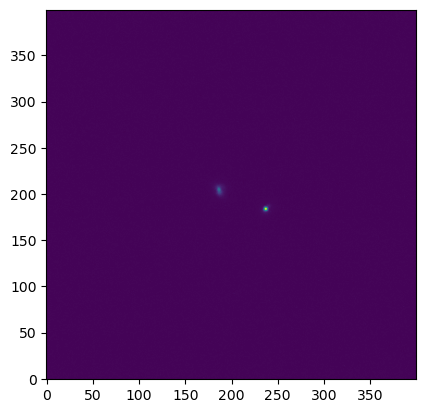

(12480, 160.0)

In [14]:
fig, ax = plt.subplots()
idx = 50
#ax.imshow(np.mean(d["data"][1005:1006], axis=0), origin="lower")
ax.imshow(d["data"][idx], origin="lower")
plt.show()
d["data"][idx].max(), np.median(d["data"][idx])

In [46]:
np.mean(d["data"], axis=(1,2))

array([157.2196, 157.3518, 157.8135, ..., 157.5162, 157.4143, 157.9766])

In [13]:
ap_im = np.mean(d["data"][:10], axis=0)
aps = find_apertures(ap_im, fwhm=9)
ap_stats = ApertureStats(ap_im, aps[0])
np.mean(ap_stats.centroid, axis=0), (ap_stats.max.max() > 16000),
ap_stats.sum

array([56649.81466287, 41954.53542167])

In [14]:
ave_im = np.mean(d['data'][:10], axis=0)
aps = find_apertures(ave_im, brightest=2)
ap_stats = ApertureStats(ave_im, aps[0])
ap_stats.centroid, ap_stats.max, np.mean(ap_stats.centroid, axis=0)

(array([[226.84209193, 192.4279562 ],
        [182.68432396, 207.55939958]]),
 array([2801.6, 1540.8]),
 array([204.76320794, 199.99367789]))

In [33]:
ap_stats.max.max()

668.8

In [34]:
x, y = np.mean(ap_stats.centroid, axis=0)
x, y

(175.57218138617034, 211.53527219935097)

In [58]:
results['N_bad']

0

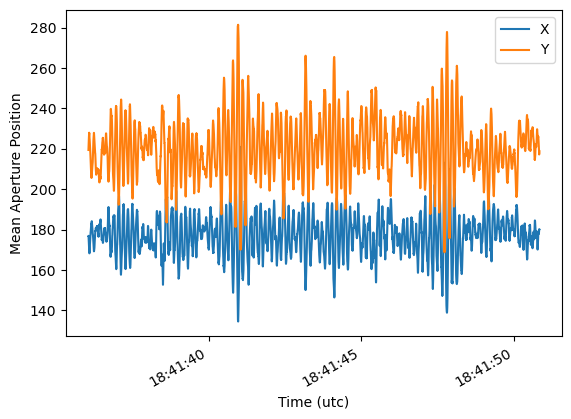

In [48]:
fig, ax = plt.subplots()
ax.plot(results["frame_times"], results["aperture_positions"][0], label='X')
ax.plot(results["frame_times"], results["aperture_positions"][1], label='Y')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Mean Aperture Position")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

In [75]:
np.argmax(results["aperture_positions"][0])

1016

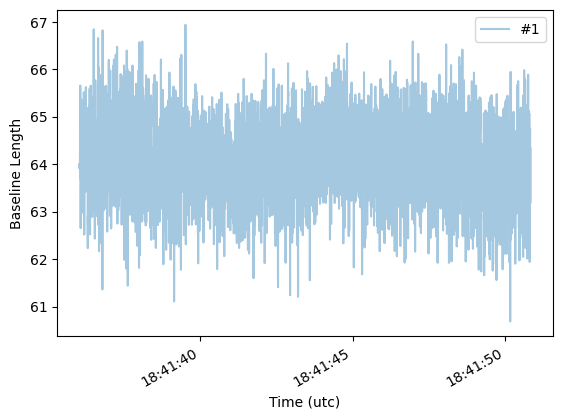

In [49]:
fig, ax = plt.subplots()
ax.plot(results["frame_times"], results["baseline_lengths"][0], label='#1', alpha=0.4)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Baseline Length")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

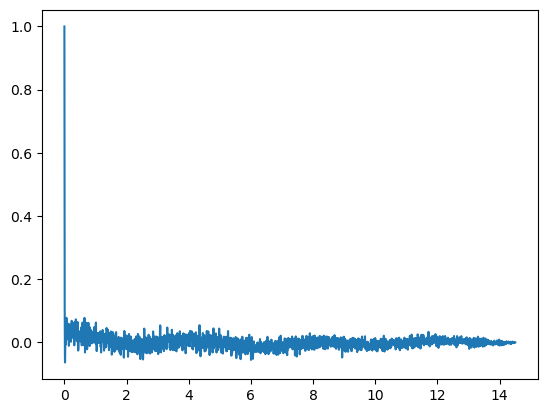

In [38]:
b0 = results["baseline_lengths"][0] - results["baseline_lengths"][0].mean()
dt = (results["frame_times"][1] - results["frame_times"][0]).to_value('sec')
autocor = np.correlate(b0, b0, mode='full')
autocor = autocor[autocor.size // 2 :]
fig = plt.figure()
plt.plot(dt * np.arange(autocor.size), autocor/autocor.max())
plt.show()

In [14]:
tobs = results['frame_times'][-1]

In [15]:
print(f'{results["seeing"]:.2f}')

1.02 arcsec


In [16]:
print(tobs.to_datetime(timezone=TimezoneInfo(utc_offset=2 * u.hour)))

2023-06-24 20:21:07.338829+02:00


In [17]:
from bs4 import BeautifulSoup
import requests

In [18]:
page = requests.get("https://suthweather.saao.ac.za/")
soup = BeautifulSoup(page.content, 'html.parser')

In [103]:
def hex2bin(str):
    """
    take a hexadecimal number as a string and convert it to a binary string
    """
    bin = [
        '0000', '0001', '0010', '0011',
        '0100', '0101', '0110', '0111',
        '1000', '1001', '1010', '1011',
        '1100', '1101', '1110', '1111'
    ]
    aa = ''
    for i in range(len(str)):
        aa += bin[int(str[i], base=16)]
    return aa

def checksum(str):
    """
    twos complement checksum as used by the ox wagon PLC
    """
    command = str[1:len(str) - 4]
    sum = 0
    for i in range(0, len(command), 2):
        byte = command[i] + command[i + 1]
        sum = sum + int(byte, base=16)
    neg = ~sum & 0xFF
    return neg + 1


In [106]:
checksum(':01101064000408' + '0000')

111

In [169]:
from timdimm_tng.wx.salt_weather_xml import parse_salt_xml as salt_wx
from timdimm_tng.wx.lcogt_weather import get_weather as lcogt_wx
from timdimm_tng.wx.lcogt_bwc2_weather import get_weather as lcogt_bwc2_wx
from timdimm_tng.wx.gfz_weather import get_weather as gfz_wx
from timdimm_tng.wx.check_wx import get_current_conditions

In [171]:
swx = salt_wx()
lwx = lcogt_wx()
gwx = gfz_wx()

In [117]:
Time(swx['TimeStamp_SAST'])

<Time object: scale='utc' format='datetime' value=2023-06-28 21:43:18>

In [180]:
cc, cc_checks = get_current_conditions()
all(cc_checks)

False

In [160]:
cc['SALT'].to(u.second).value

-7198.680580000004

In [172]:
swx, lwx, gwx

({'bms_validity': 511,
  'DateTime': '2023-06-28_22:49:27.62',
  'Bar_Press': 821.6397000000001,
  'DewTemp': 2.41875,
  'Rel_Hum': 97.99226,
  'Wind_speed': 27.98064,
  'Wind_dir': 260.69394,
  'Temp': 2.70172,
  'Rain': 0,
  'TimeStamp_SAST': datetime.datetime(2023, 6, 28, 22, 49, 28),
  'SkyCon': 'DRY',
  'Valid': True},
 {'TimeStamp_SAST': datetime.datetime(2023, 6, 28, 22, 47),
  'Temp': 2.0,
  'Wind_speed': 25.2,
  'Wind_dir': 240.0,
  'Rel_Hum': 99.0,
  'DewTemp': 1.9,
  'Bar_Press': 823.0,
  'SkyCon': 'DRY',
  'Valid': True},
 {'TimeStamp_SAST': datetime.datetime(2023, 6, 28, 22, 41),
  'Bar_Press': 821.84,
  'Wind_dir': 276.6,
  'Wind_speed': 26.3,
  'SkyCon': 'DRY',
  'Temp': 2.1,
  'Rel_Hum': 100.0,
  'DewTemp': 2.1,
  'Valid': True})

In [3]:
hadar = SkyCoord.from_name("Hadar")

In [4]:
hadar.to_string('hmsdms')

'14h03m49.40534952s -60d22m22.9265832s'

In [5]:
salt_loc = EarthLocation.of_site('Southern African Large Telescope')

In [6]:
hadar.transform_to(TETE(obstime=Time.now(), location=salt_loc)).to_string('hmsdms')

'14h05m29.60109118s -60d29m23.41570995s'

In [10]:
SkyCoord.from_name("Alnair").to_string('hmsdms')

'22h08m13.984728s -46d57m39.507768s'

In [33]:
t = ascii.read("../src/timdimm_tng/star.lst", format='fixed_width', delimiter='|')
t

HR,Name,RA2000,Dec2000,Vmag,B-V,SED,SpType,Duplicity
int64,str14,str8,str9,float64,float64,str3,str12,str15
98,Bet Hyi,0:25:45,-77:15:15,2.8,0.62,G05,G2IV,--
99,Ankaa,0:26:17,-42:18:22,2.39,1.09,K03,K0III,"0.1"" dm=0.0"
188,Diphda,0:43:35,-17:59:12,2.04,1.02,K03,G9.5IIICH-1,--
472,Achernar,1:37:43,-57:14:12,0.46,-0.16,B55,B3Vpe,--
591,Alp Hyi,1:58:46,-61:34:11,2.86,0.28,F05,F0V,--
1790,Bellatrix,5:25:08,+06:20:59,1.64,-0.22,B05,B2III,"179"" dm=10.5"
1865,Arneb,5:32:44,-17:49:20,2.58,0.21,F05,F0Ib,"AB 36"" dm=8.5"
1903,Alnilam,5:36:13,-01:12:07,1.7,-0.19,B05,B0Ia,"180"" dm=8.7"
1956,Phact,5:39:39,-34:04:27,2.64,-0.12,B55,B7IVe,"14"" dm=9.7"


In [34]:
coord_list = []
for r in t:
    print(r['Name'])
    coord_list.append(SkyCoord.from_name(r['Name']))

Bet Hyi
Ankaa
Diphda
Achernar
Alp Hyi
Bellatrix
Arneb
Alnilam
Phact
Saiph
Furud
Mirzam
Canopus
Sirius
Tau Pup
Omi2 CMa
Wezen
Pi Pup
Aludra
Procyon
Rho Pup
Suhail
Miaplacidus
Aspidiske
Kap Vel
Alphard
The Car
Mu  Vel
Del Cen
Del Cru
Gienah
Bet Crv
Alp Mus
Gam Cen
Mimosa
Gam Hya
Iot Cen
Spica
Eps Cen
Mu  Cen
Zet Cen
The Cen
Eta Cen
Alp Lup
Zubenelgenubi
Bet Lup
Gam TrA
Zubeneschamali
Bet TrA
Pi  Sco
Bet Sco
Sig Sco
Tau Sco
Atria
Eps Sco
Mu  Sco
Bet Ara
Lesath
Alp Ara
Shaula
The Sco
Kap Sco
Iot1 Sco
Alnasl
Kaus Media
Kaus Australis
Kaus Borealis
Nunki
Pi Sgr
Peacock
Deneb Algedi
Gam Gru
Alnair
Alp Tuc
Fomalhaut


In [36]:
t['Coordinates'] = coord_list

In [38]:
t.write("star_list.ecsv", format="ascii.ecsv", overwrite=True)

In [39]:
new_t = Table.read("star_list.ecsv", format="ascii.ecsv")

In [43]:
new_t

HR,Name,RA2000,Dec2000,Vmag,B-V,SED,SpType,Duplicity,Coordinates
,,,,,,,,,"deg,deg"
int64,str14,str8,str9,float64,float64,str3,str12,str15,SkyCoord
98,Bet Hyi,0:25:45,-77:15:15,2.8,0.62,G05,G2IV,--,"6.437793155,-77.25424612"
99,Ankaa,0:26:17,-42:18:22,2.39,1.09,K03,K0III,"0.1"" dm=0.0","6.571047515,-42.305987194"
188,Diphda,0:43:35,-17:59:12,2.04,1.02,K03,G9.5IIICH-1,--,"10.897378736,-17.986606316"
472,Achernar,1:37:43,-57:14:12,0.46,-0.16,B55,B3Vpe,--,"24.428522833,-57.236752806"
591,Alp Hyi,1:58:46,-61:34:11,2.86,0.28,F05,F0V,--,"29.69224409758834,-61.56982215319751"
1790,Bellatrix,5:25:08,+06:20:59,1.64,-0.22,B05,B2III,"179"" dm=10.5","81.282763557,6.349703264"
1865,Arneb,5:32:44,-17:49:20,2.58,0.21,F05,F0Ib,"AB 36"" dm=8.5","83.18256716167,-17.82228927222"
1903,Alnilam,5:36:13,-01:12:07,1.7,-0.19,B05,B0Ia,"180"" dm=8.7","84.053388941,-1.201919136"


In [1]:
new_t['Name'] == 'Tchou'

NameError: name 'new_t' is not defined

In [30]:
Time.now().isot

'2024-01-19T05:01:14.033'

In [34]:
status = {
    'target': "Tchou",
    'az': 234, # * u.degree,
    'el': 45, # * u.degree,
    'ra': 6, # * u.hourangle,
    'dec': -34, # * u.degree,
    'ha': 2, # * u.hourangle,
    'airmass': 1.54
}

with open(Path.home() / "pointing_status.json", 'w') as fp:
    fp.write(json.dumps(status, indent=4))

In [4]:
df['seeing']

ut
2024-02-20 19:06:02.620    2.01
2024-02-20 19:07:00.636    1.22
2024-02-20 19:07:59.250    1.31
2024-02-20 19:08:57.368    1.36
2024-02-20 19:09:55.999    1.20
                           ... 
2024-04-29 19:27:03.420    1.40
2024-04-29 19:28:01.815    1.46
2024-04-29 19:29:00.709    1.40
2024-04-29 19:29:59.179    1.49
2024-04-29 19:30:57.511    1.52
Name: seeing, Length: 24275, dtype: float64

In [11]:
def fix_seeing(seeing):
    aperture_diameter = 50 * u.mm
    baseline = 200 * u.mm
    wavelength = 0.64 * u.micron
    b = (baseline / aperture_diameter).decompose().value
    k = 0.364 * (1.0 - 0.532 * b ** (-1.0 / 3.0) - 0.024 * b ** (-7.0 / 3.0))
    pixel_scale = (0.742 * u.arcsec).to(u.radian).value

    seeing = (seeing * u.arcsec).to(u.radian).value
    variance = k * (seeing / (0.98 * ((aperture_diameter / wavelength).decompose().value ** 0.2))) ** (5/3)
    sigma = variance / pixel_scale ** 2  # correct for the boo-boo i made in the code
    new_seeing = timdimm_seeing(sigma)
    return new_seeing.value

In [56]:
df['fixed_seeing'] = df['seeing'].apply(fix_seeing)
df = df[df['fixed_seeing'] < 15]

In [57]:
np.median(df['fixed_seeing'])


1.2974409007348449

In [58]:
df['fixed_seeing'].describe()

count    23899.000000
mean         1.444648
std          0.625398
min          0.212372
25%          1.052711
50%          1.297441
75%          1.656031
max          9.798283
Name: fixed_seeing, dtype: float64

In [62]:
df['seeing'].describe()

count    23899.000000
mean         1.356747
std          0.264665
min          0.530000
25%          1.180000
50%          1.310000
75%          1.480000
max          3.600000
Name: seeing, dtype: float64

In [59]:
df.to_csv(Path.home() / "SAAO" / "fixed_seeing.csv")

In [60]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(df['fixed_seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 5.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(df['fixed_seeing'])
fit_median = exp_mu + loc

0.4263500874420954 0.19857283057073516 1.1310985158657807


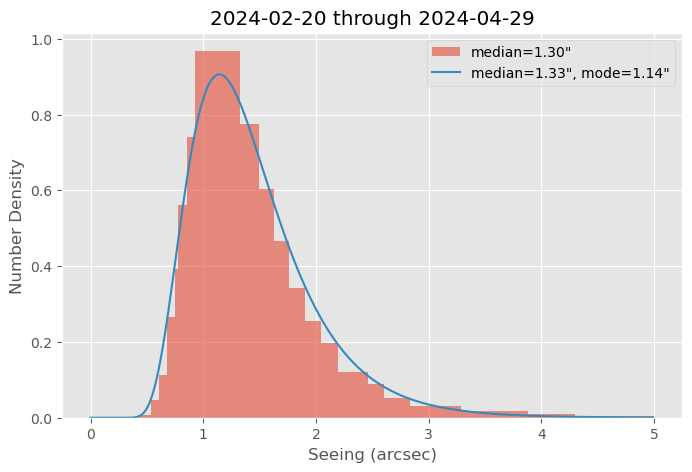

In [61]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    hist(df['fixed_seeing'], density=True, bins='blocks', range=(0.0, 5.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("2024-02-20 through 2024-04-29")
    plt.legend(["median=%.2f\"" % (median), "median=%.2f\", mode=%.2f\"" % (fit_median, mode)])
    plt.savefig("2024_timdimm.png")
plt.show()